<a href="https://colab.research.google.com/github/adrianacupp/NLP_with_Transformers/blob/main/Text_Clustering_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import libraries and data

In [1]:
import re
import nltk
import time
import os.path
from os import path
import pprint
import os.path
from os import path
import numpy as np
import pandas as pd
from string import *

In [2]:
import seaborn as sns
from spacy import displacy
import transformers as ppb

In [3]:
import torch
import torch.nn.functional as F

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

In [7]:
#pip install -U sentence-transformers

In [8]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score

In [9]:
from sklearn.decomposition import PCA

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#read the file
df = pd.read_excel('/content/input.xlsx')
print(df.head())
print(df.info())

                                              corpus
0  Gap-Based Education, Changing Competence, and ...
1    Science Education in the Preclinical Curriculum
2  SPECIAL TUBERCULOSIS EXAMINATIONS IN THE MILIT...
3  Adaptive tracking control design of constraine...
4  Archives of Internal Medicine Reader's Choice:...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   corpus  972 non-null    object
dtypes: object(1)
memory usage: 7.7+ KB
None


## EDA

In [12]:
#how long are the titles?
df['length'] = df['corpus'].str.split().apply(len)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,972.0,10.195473,5.472792,2.0,7.0,9.0,13.0,47.0


<Axes: >

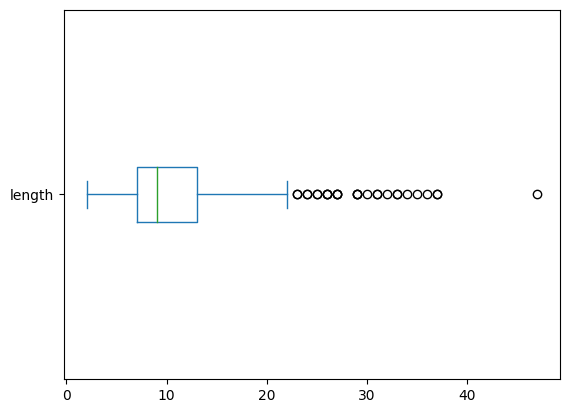

In [13]:
df['length'].plot(kind='box', vert=False)

<Axes: ylabel='Frequency'>

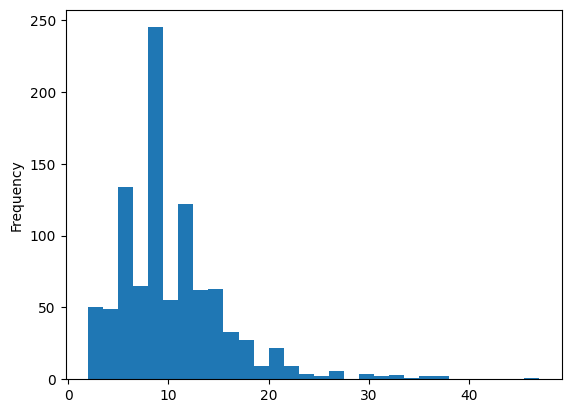

In [14]:
df['length'].plot(kind='hist', bins=30)

### Word Frequency/BOW

In [15]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [16]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [18]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [19]:
df['tokens'] = df['corpus'].apply(prepare, pipeline=pipeline)

In [20]:
df['num_tokens'] = df['tokens'].map(len)

In [21]:
df.tokens.head()

0    [gap-based, education, changing, competence, d...
1        [science, education, preclinical, curriculum]
2    [special, tuberculosis, examinations, military...
3    [adaptive, tracking, control, design, constrai...
4    [archives, internal, medicine, reader, choice,...
Name: tokens, dtype: object

In [22]:
from collections import Counter

In [23]:
counter = Counter()

df['tokens'].map(counter.update)

0      None
1      None
2      None
3      None
4      None
       ... 
967    None
968    None
969    None
970    None
971    None
Name: tokens, Length: 972, dtype: object

In [24]:
print(counter.most_common(5))

[('education', 261), ('military', 249), ('robot', 229), ('sport', 210), ('medical', 181)]


In [25]:
#transform the counter into a Pandas DataFrame
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [26]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
education,261
military,249
robot,229
sport,210
medical,181


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

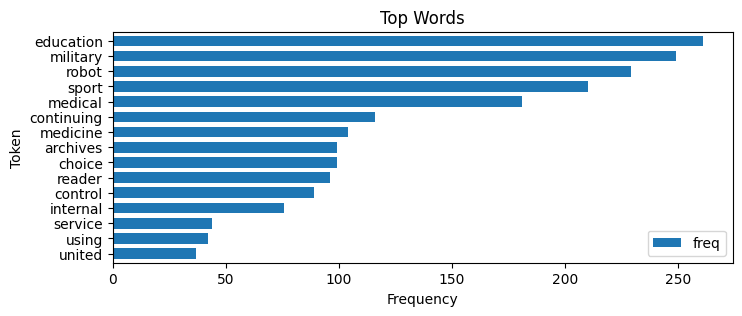

In [27]:
#frequency diagrams
ax = freq_df.head(15).plot(kind='barh', width=0.7, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

## BERT Base Implementation - Last Hidden State



### Tokenizing

In [28]:
from transformers import AutoTokenizer, AutoModel

model_ckpt = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [29]:
#before tokenizing the data, I need to pass Pandas dataframe as a list of Series
texts = df['corpus'].tolist()
tokenized_texts = tokenizer(texts, padding=True, return_tensors='pt')

In [30]:
tokenized_texts['input_ids']

tensor([[  101,  6578,  1011,  ...,     0,     0,     0],
        [  101,  2671,  2495,  ...,     0,     0,     0],
        [  101,  2569, 15877,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  2991,  ...,     0,     0,     0],
        [  101,  2474, 18143,  ...,     0,     0,     0],
        [  101,  4684,  8957,  ...,     0,     0,     0]])

In [31]:
tokenized_texts['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [32]:
print("Input IDs shape:", tokenized_texts['input_ids'].shape)
print("Attention mask shape:", tokenized_texts['attention_mask'].shape)

Input IDs shape: torch.Size([972, 108])
Attention mask shape: torch.Size([972, 108])


### Convert token encoding to embeddings

In [33]:
model_ckpt = "sentence-transformers/bert-base-nli-mean-tokens"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [34]:
inputs = {
    'input_ids': tokenized_texts['input_ids'],
    'attention_mask': tokenized_texts['attention_mask']
}

In [35]:
# Define mean pooling function
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [36]:
# Generate embeddings with MEAN POOLING
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = mean_pooling(outputs, inputs['attention_mask'])

In [37]:
embeddings.shape

torch.Size([972, 768])

### Plot similarity matrix

In [38]:
# Calculate cosine similarity
embeddings_np = embeddings.numpy()
reshaped_embeddings = embeddings_np.reshape(embeddings_np.shape[0], -1)

similarity_matrix = cosine_similarity(reshaped_embeddings)
print("Similarity matrix shape:", similarity_matrix.shape)

Similarity matrix shape: (972, 972)


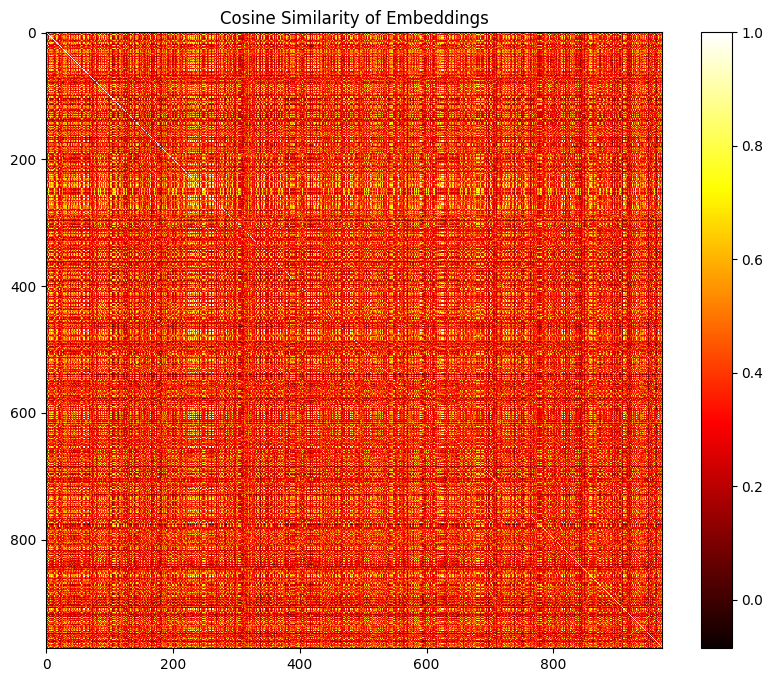

In [39]:
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.title('Cosine Similarity of Embeddings')
plt.colorbar()
plt.show()

## KMeans

In [40]:
n_samples, embedding_dim = embeddings_np.shape
print( n_samples, embedding_dim)

972 768


Elbow Plot

In [41]:
def plot_elbow_method(embedding):

    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(embedding)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

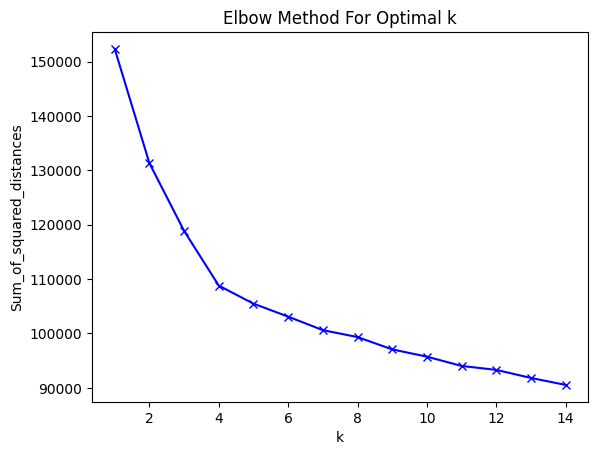

In [42]:
plot_elbow_method(embeddings_np)

In [43]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_np.reshape(n_samples, -1))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Dimensionality Reduction

PCA

In [44]:
pca = PCA(n_components=10)
embeddings_reduced = pca.fit_transform(embeddings_np.reshape(n_samples, -1))

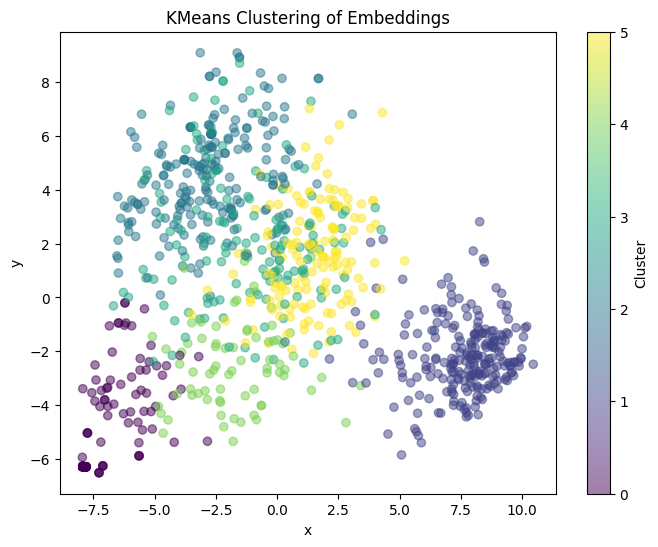

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('KMeans Clustering of Embeddings')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Cluster')
plt.show()

UMAP

In [66]:
#pip install umap

In [70]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.7 MB/s eta 0:00:00


In [46]:
import umap.umap_ as umap

In [47]:
umap_embeddings = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2,
                            metric='cosine').fit_transform(embeddings_np)

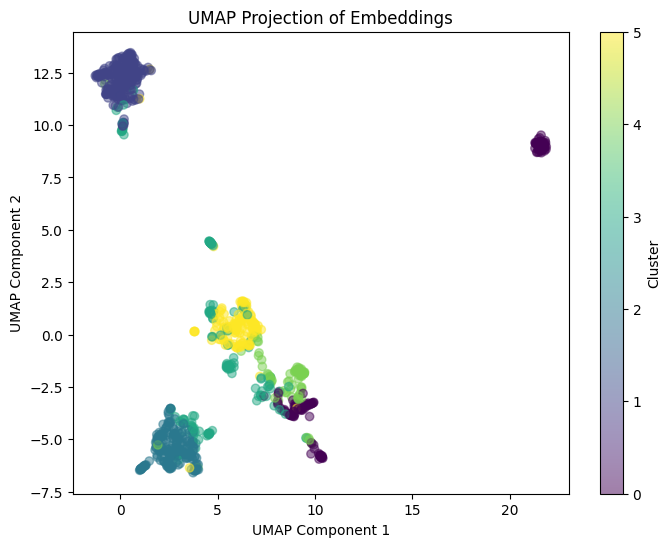

In [48]:
# Visualize UMAP embeddings
plt.figure(figsize=(8, 6))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('UMAP Projection of Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster')
plt.show()